In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import sys
import glob
sys.path.append('../../../src')

from common import common, transform, json, video
from common.functions import cos_similarity, gauss
from common.json import IA_FORMAT, START_IDX, GA_FORMAT, ATTENTION_FORMAT
from common.default import PASSING_DEFAULT
from common.object_point import OBJECT_POINTS
from individual_activity.individual_activity import IndividualActivity
from display.individual_activity import disp_individual_activity
from display.tracking import disp_tracking
from display.heatmap import Heatmap

# Attention をロード

In [2]:
# group attention のデータはまだない
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'attention'},
    {'room_num': '08', 'date': '20210915', 'option': 'attention'},
    {'room_num': '09', 'date': '20210706', 'option': 'attention'}
]

In [3]:
attentions = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
    
    for i, path in enumerate(tqdm(dirs)):
        path = f'{path}/json/group_activity.json'
        json_data = json.load(path)
        key = f"{room_num}_{date}_{i + 1:02d}"
        attentions[key] = json_data["attention"]

{'room_num': '02', 'date': '20210903', 'option': 'attention'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]


{'room_num': '08', 'date': '20210915', 'option': 'attention'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.76s/it]


{'room_num': '09', 'date': '20210706', 'option': 'attention'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.35s/it]


# 対象物に対するヒートマップを作成
https://qiita.com/masataka46/items/cb5b05090746c7f3b826

In [4]:
def heatmap(object_point, attention_data, sigma=1, th=0.01):
    px = object_point[0]
    py = object_point[1]
    
    heatmap_data = {}
    for data in tqdm(attention_data):
        frame_num = data[ATTENTION_FORMAT[0]]
        x, y = data[ATTENTION_FORMAT[2]]
        count = data[ATTENTION_FORMAT[4]]
        gauss = np.exp(-((x - px)**2 + (y - py)**2) / (2 * count**2))
        
        if frame_num not in heatmap_data:
            heatmap_data[frame_num] = []
        
        if gauss >= th:
            heatmap_data[frame_num].append({
                "point": (x, y),
                "gauss": gauss
            })
            
    return heatmap_data

In [5]:
heatmap_dict = {}
for key, attention_data in attentions.items():
    room_num, date, num = key.split("_")
    object_points = OBJECT_POINTS[room_num][date][num]
    for i, object_point in enumerate(object_points):
        heatmap_data = heatmap(object_point, attention_data)
        new_key = f"{key}_{i + 1}"
        heatmap_dict[new_key] = heatmap_data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2322390/2322390 [00:04<00:00, 482830.75it/s]


# 動画作成

In [6]:
def display_heatmap(object_point, heatmap_data, heatmap_cls, field, max_radius=20, alpha=0.2):
    copy = field.copy()
    cv2.circle(copy, tuple(object_point), 10, (0, 0, 0), -1)
    
    for data in heatmap_data:
        point = data["point"]
        value = data["gauss"]

        color = heatmap_cls.colormap(value)

        # calc radius of circle
        max_value = heatmap_cls.xmax
        radius = int(value / max_value * max_radius)
        if radius == 0:
            radius = 1

        cv2.circle(copy, point, radius, color, thickness=-1)

    field = cv2.addWeighted(copy, alpha, field, 1 - alpha, 0)

    return field

In [7]:
def combine_image(frame, field):
    ratio = 1 - (field.shape[0] - frame.shape[0]) / field.shape[0]
    size = [int(field.shape[1] * ratio), int(field.shape[0] * ratio)]
    if frame.shape[0] != size[1]:
        # 丸め誤差が起きる
        size[1] = frame.shape[0]
    field = cv2.resize(field, size)
    frame = np.concatenate([frame, field], axis=1)

    return frame


def display(
    video_path,
    out_path,
    individual_activity_json_path,
    heatmap_data,
    heatmap_cls,
    field,
    object_point,
):
    print(out_path)
    print("Writing video frames...")

    # load datas
    individual_activity_datas = json.load(individual_activity_json_path)

    # load video
    capture = video.Capture(video_path)

    # frames_lst = [[] for _ in range(len(out_paths))]
    cmb_img = combine_image(capture.read(), field)
    size = cmb_img.shape[1::-1]
    writer = video.Writer(out_path, capture.fps, size)

    # reset capture start position
    capture.set_pos_frame(0)

    for frame_num in tqdm(range(capture.frame_num)):
        # read frame
        frame = capture.read()

        # フレームごとにデータを取得する
        frame_individual_activity_datas = [
            data for data in individual_activity_datas if data["frame"] == frame_num
        ]

        # フレーム番号を表示
        cv2.putText(
            frame,
            "Frame:{}".format(frame_num + 1),
            (10, 50),
            cv2.FONT_HERSHEY_PLAIN,
            2,
            (0, 0, 0),
        )

        # copy raw field image
        field_tmp = field.copy()

        # draw tracking result
        frame = disp_tracking(frame_individual_activity_datas, frame)

        # draw individual activity
        field_tmp = disp_individual_activity(
            frame_individual_activity_datas, field_tmp
        )

        # draw heatmap
        field_tmp = display_heatmap(object_point, heatmap_data[frame_num], heatmap_cls, field_tmp)

        # write video
        writer.write(combine_image(frame, field_tmp))


def get_field(room_num):
    field_path = os.path.join(common.data_dir, room_num, 'field.png')
    return cv2.imread(field_path)

In [8]:
heatmap_cls = Heatmap([0, 1])

for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
        
    field = get_field(room_num)
    
    for i, path in enumerate(dirs):
        num = f"{i + 1:02d}"
        ia_json_path = os.path.join(path, 'json', 'individual_activity.json')
        video_path = os.path.join(path, 'video', f'pose_{num}.mp4')
        out_dir = os.path.join(path, 'out')
        cap = video.Capture(video_path)
        
        object_points = OBJECT_POINTS[room_num][date][num]
        for j, object_point in enumerate(object_points):
            print(object_point)
            out_path = os.path.join(out_dir, f'attention_object{j + 1}.mp4')
            key = f"{room_num}_{date}_{i + 1:02d}_{j + 1}"
            heatmap_data = heatmap_dict[key]
            display(
                video_path,
                out_path,
                ia_json_path,
                heatmap_data,
                heatmap_cls,
                field,
                object_point,
            )

{'room_num': '09', 'date': '20210706', 'option': 'attention'}
(685, 780)
C:\Users\k2111\program\research\data/09/20210706/attention\01\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [03:01<00:00, 41.43it/s]


(367, 415)
C:\Users\k2111\program\research\data/09/20210706/attention\01\out\attention_object2.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [02:58<00:00, 41.99it/s]


(685, 780)
C:\Users\k2111\program\research\data/09/20210706/attention\02\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10800/10800 [05:46<00:00, 31.20it/s]


(510, 800)
C:\Users\k2111\program\research\data/09/20210706/attention\02\out\attention_object2.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10800/10800 [05:50<00:00, 30.80it/s]


(367, 415)
C:\Users\k2111\program\research\data/09/20210706/attention\02\out\attention_object3.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10800/10800 [05:35<00:00, 32.14it/s]


(685, 780)
C:\Users\k2111\program\research\data/09/20210706/attention\03\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [02:30<00:00, 39.99it/s]


# lossを計算

In [32]:
def focal_loss(data, alpha=2):
    x = []
    for val in data:
        x.append(val["gauss"])
    loss = np.log(x) * np.power(1 - np.array(x), alpha)
    return - loss.mean()

In [43]:
loss_dict = {}
for key, heatmap_data in heatmap_dict.items():
    loss_data = {}
    for frame_num, data in heatmap_data.items():
        if len(data) > 0:
            loss = focal_loss(data, 2)
            loss_data[frame_num] = loss
        else:
            loss_data[frame_num] = np.nan
            
    loss_dict[key] = loss_data

02_20210903_01_1


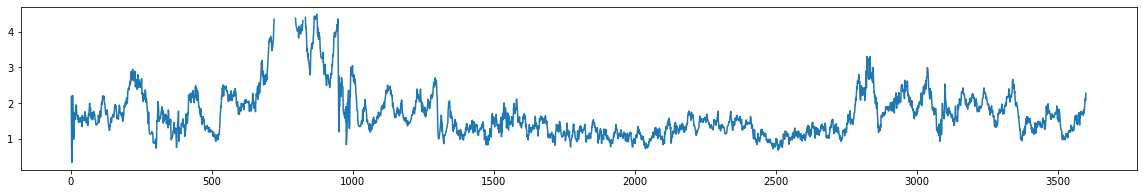

02_20210903_01_2


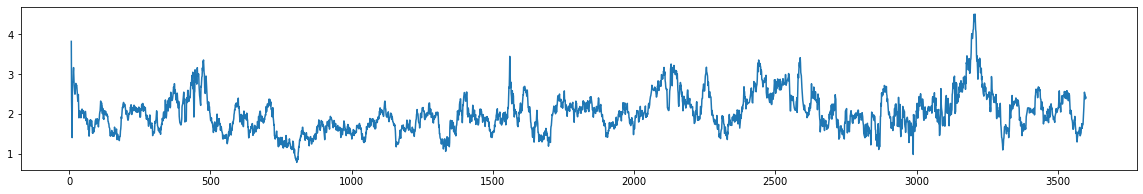

02_20210903_02_1


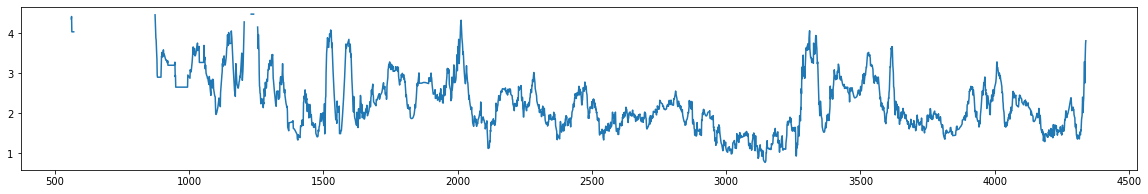

02_20210903_02_2


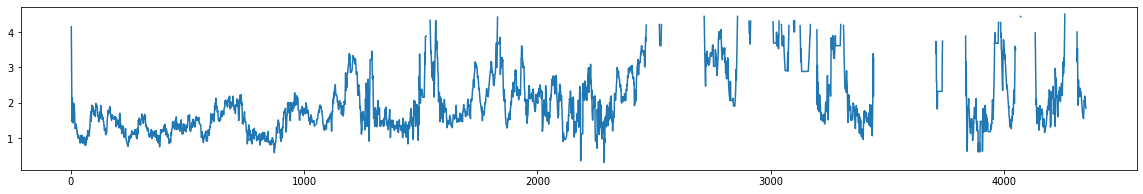

08_20210915_01_1


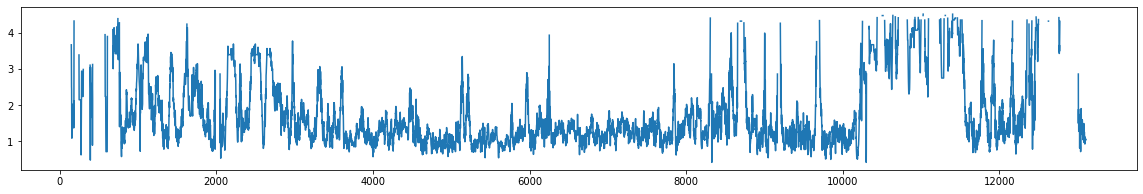

08_20210915_01_2


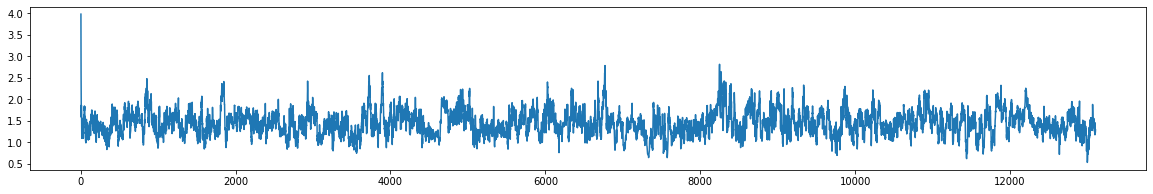

08_20210915_02_1


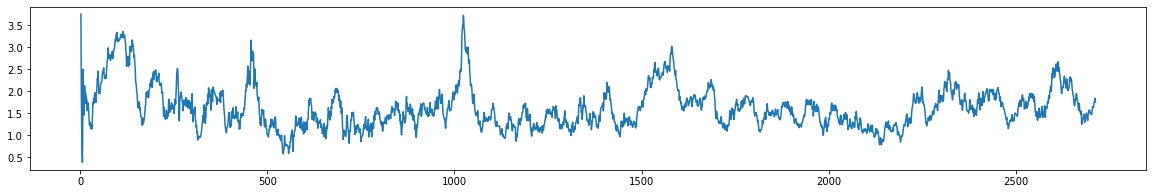

08_20210915_02_2


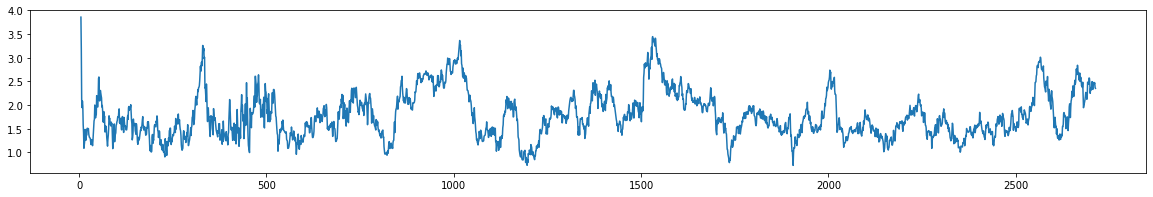

09_20210706_01_1


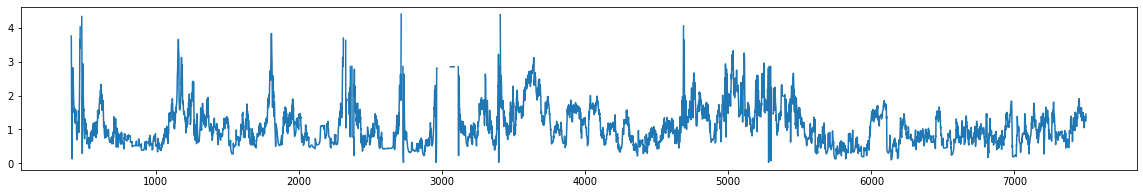

09_20210706_01_2


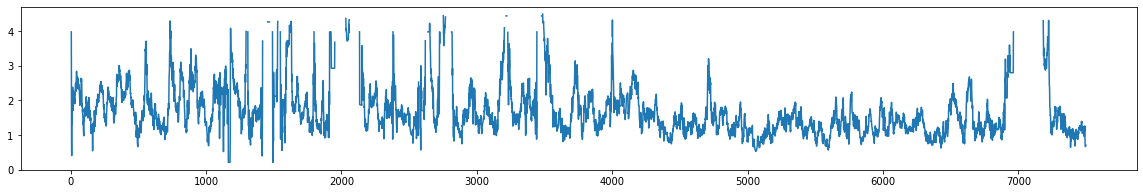

09_20210706_02_1


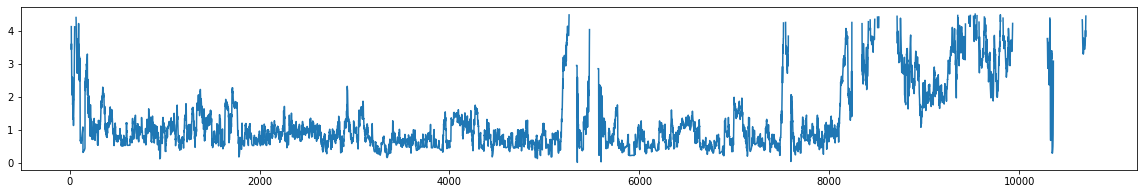

09_20210706_02_2


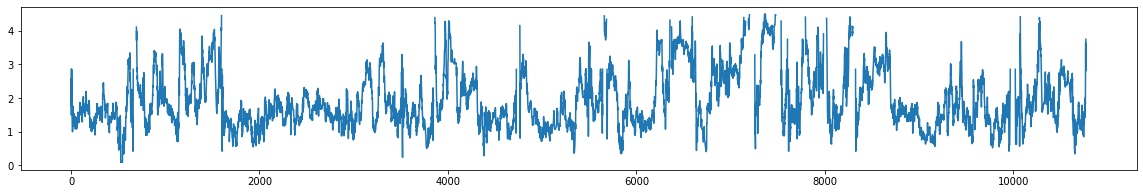

09_20210706_02_3


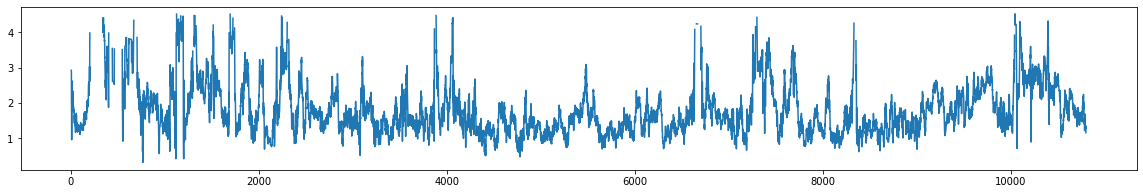

09_20210706_03_1


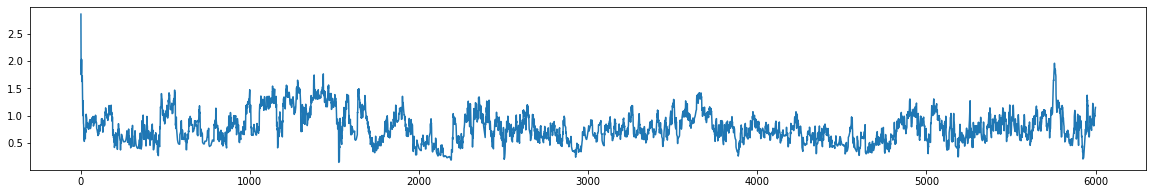

In [44]:
for key, loss_data in loss_dict.items():
    print(key)
    lst = sorted(loss_data.items())
    x, y = zip(*lst)
    plt.figure(figsize=(20, 3))
    plt.plot(x, y)
    plt.show()